In [1]:
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams['figure.figsize'] = [2, 1]

In [2]:
import timeit
import scipy.linalg as spl
from scipy.spatial.distance import cdist

We will use $t_f=1$ and $x_0=(1,\ldots)$ to simplify computations for a $\dim(D)=10$ problem.

We will let the diagonal values $d_i=2$.

In [3]:
class ode_model:
    # NOTE: scipy version must be >=1.9.0 to support 
    # evaluation of scipy.linalg.expm([N x d x d])-type arrays
    def __init__(self,d,dvals=2.,x0=1.):
        self.d = d
        self.dvals = dvals*np.ones(self.d)
        self.x0 = x0*np.ones(self.d)
        
    def get_A(self,ud_samp,ld_samp):
        this_n = ud_samp.shape[0]
        A = []
        for i,(uval,lval) in enumerate(zip(ud_samp,ld_samp)):
            A.append(np.diag(uval,1) + np.diag(lval,-1) + np.diag(self.dvals))
        return A
    
    def QoI(self,A_list,t=1.):
        # assuming x0 = 1.
        output = np.sum(spl.expm(t*np.array(A_list)),axis=-1)            
        return output
    
    def solve(self,tmeas,A_list):
        # assuming x0 = 1.
        output = np.sum(spl.expm(tmeas[None,:,None,None]*np.expand_dims(A_list,axis=1)),axis=-1)
        return output


In [4]:
# parameters
d = 3
tf = 1.
x0 = np.ones(d)
print('dim(Lambda) = ',2*(d-1))
print('dim(D) = ',d)

# define ode model
this_ode = ode_model(d)

dim(Lambda) =  4
dim(D) =  3


To generate samples from the model, we will assume that the diagonals follow scaled-beta distributions with support on $[-1,1]$, i.e.,

\begin{align}
\lambda_{i,j}&\sim \beta eta(\alpha_{i,j}\ ,\ \beta_{i,j}).
\end{align}

where $(\alpha_{i,j},\beta_{i,j})$ are the standard parameters of the beta distribution.

For our initial distributions, we will let $\alpha_{i,j}=\beta_{i,j}=1$ so that :

\begin{align}
\lambda_{i,j}&\sim \beta eta(1,1) = U[-1,1] \quad \forall i,j
\end{align}

On the other hand, we will generate observed samples using:

\begin{align}
\left\{(a_k,b_k)\right\} &= \{(3,5),(4,8),(5,11),\ldots\}\\
\\
(\alpha_{i<j},\beta_{i<j}) &= \begin{cases} (a_j,b_j) & j \text{ odd} \\
(b_j,a_j) & j \text{ even} \\
\end{cases} \\
(\alpha_{i>j},\beta_{i>j}) &= \begin{cases} (b_i,a_i) & i \text{ odd} \\
(a_i,b_i) & i \text{ even} \\
\end{cases}
\end{align}

so that

\begin{align}
A(\lambda) = \begin{pmatrix} d_{0} & \lambda_{0,1}\sim\beta eta(3,5) & 0  &\cdots \\
\lambda_{1,0}\sim\beta eta(5,3) & d_{1} & \lambda_{1,2}\sim\beta eta(8,4) & 0  \\
0 & \lambda_{2,1}\sim\beta eta(4,8) & d_{2} & \ddots  \\
\vdots & 0 & \ddots & \ddots  \\
\end{pmatrix}
\end{align}



In [5]:
class Gen_Diag_Dist:
    def __init__(self,d,ab_init=(3,5),ab_rate=(1,3)):
        self.d = d        
        self.loc = -1
        self.scale = 2
        self.a_init,self.b_init = ab_init
        self.a_rate,self.b_rate = ab_rate
    
    def get_ab_pattern(self):
        ab_list = []
        for j in range(self.d-1):
            aval,bval = self.a_init+self.a_rate*j,self.b_init+self.b_rate*j
            
            # swap who is who
            if j%2==0:
                a,b = aval,bval
            else:
                a,b = bval,aval
            
            ab_list.append((a,b))
            
        return ab_list
    
    def rvs(self,n):
        # upper and lower second diagonals
        ud = np.zeros([n,self.d-1])
        ld = np.zeros([n,self.d-1])
        
        this_ab_list = self.get_ab_pattern()
        
        for j,(a,b) in enumerate(this_ab_list):        
            ud[:,j] = sps.beta(a,b,loc=self.loc,scale=self.scale).rvs(n)
            ld[:,j] = sps.beta(b,a,loc=self.loc,scale=self.scale).rvs(n)            
        
        return np.stack([ud,ld])
    
    def diag_pdf(self,x,diag):
        ys = []
        this_ab_list = self.get_ab_pattern()
        
        for (a,b) in this_ab_list:
            if diag==1:
                y = sps.beta(a,b,loc=self.loc,scale=self.scale).pdf(x)
            elif diag==-1:
                y = sps.beta(b,a,loc=self.loc,scale=self.scale).pdf(x)
            else:
                raise ValueError ('diag must be 1 or -1.')
            
            ys.append(y)
            
        return ys
        
    def logpdf(self,udx,ldx):
        logpdf = np.zeros(len(udx))
        this_ab_list = self.get_ab_pattern()
        
        for k,(this_ux,this_lx) in enumerate(zip(udx.T,ldx.T)):
            # get parameters
            this_ua,this_ub = this_ab_list[k]
            this_lb,this_la = this_ua,this_ub
            
            # upper logpdf
            logpdf += sps.beta(this_ua,this_ub,
                               loc=self.loc,scale=self.scale).logpdf(this_ux)
            # lower logpdf
            logpdf += sps.beta(this_la,this_lb,
                               loc=self.loc,scale=self.scale).logpdf(this_lx)
        return logpdf
    
    def pdf(self,udx,ldx):
        return np.exp(self.logpdf(udx,ldx))

In [6]:
# lambda gen. dist values
n_obs = int(5e3)
lam_gen_dist = Gen_Diag_Dist(d)
lam_gen_sample = lam_gen_dist.rvs(n_obs)

# lambda initial dist values
n_pred = int(5e3)
lam_init_dist = Gen_Diag_Dist(d,ab_init=(1,1),ab_rate=(0,0))
lam_init_sample = lam_init_dist.rvs(n_pred)

# lambda importance sample
lam_import_dist = Gen_Diag_Dist(d,ab_init=(2,3),ab_rate=(0,0))
lam_import_sample = lam_import_dist.rvs(n_pred)


Here we just verify the samples in $\Lambda$ are what we expect.

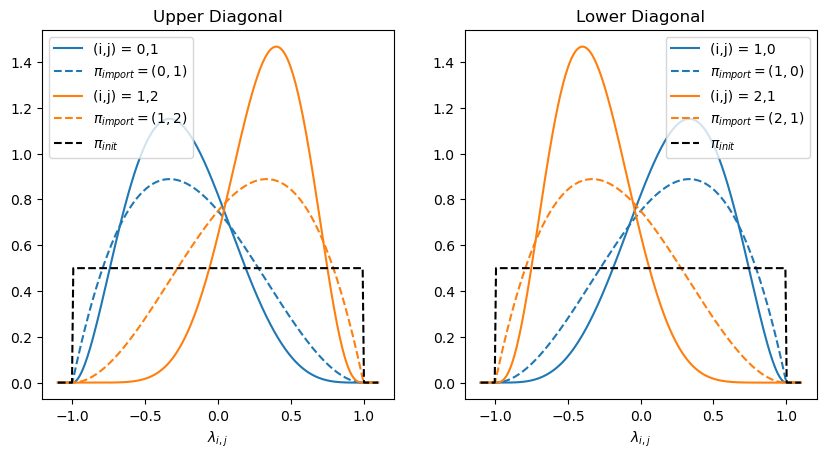

In [7]:
x = np.linspace(-1.1,1.1,250)

ys_gen = []
ys_init = []
ys_import = []
for diag in [1,-1]:
    ys_gen.append(lam_gen_dist.diag_pdf(x,diag))
    ys_init.append(lam_init_dist.diag_pdf(x,diag))
    ys_import.append(lam_import_dist.diag_pdf(x,diag))


fig,axes = plt.subplots(1,2)
fig.set_figwidth(len(axes)*5)
titles = ['Upper Diagonal','Lower Diagonal']
for k,ax in enumerate(axes):
    for i,y in enumerate(ys_gen[k]):
        labels = (i,i+1) if k==0 else (i+1,i)
        ax.plot(x,y,label='(i,j) = {},{}'.format(*labels))
        ax.plot(x,ys_import[i][k],ls='--',color='C{}'.format(i),
                label='$\pi_{{import}}=({},{})$'.format(*labels))        
#         ax.hist(lam_gen_sample[k][:,i],density=True,alpha=0.2,
#                 color='C{}'.format(i))
    
    ax.plot(x,ys_init[0][k],ls='--',color='k',label='$\pi_{{init}}$')

    ax.set_xlabel('$\lambda_{{i,j}}$')
    ax.set_title(titles[k])
    ax.legend()

Here we test that the maximum mean discrepancy metric in $\Lambda$.

In [9]:
# for computing the maximum mean discrepancy
def my_rbf_kernel(valsA,valsB):
    gamma = 1.0/valsA.shape[1]
    K = cdist(valsA,valsB,'sqeuclidean')
    K *= -gamma
    np.exp(K,K)
    return K

def my_mmd(valsA,valsB):
    mmd = 0.
    mmd += np.mean(my_rbf_kernel(valsA,valsA))
    mmd += np.mean(my_rbf_kernel(valsB,valsB))
    mmd += -2*np.mean(my_rbf_kernel(valsA,valsB))
    return mmd

In [10]:
# for evaluating 
n_monte = int(4e3)
lam_gen_monte = lam_gen_dist.rvs(n_monte)
lam_init_monte = lam_init_dist.rvs(n_monte)


In [11]:
# check mmd suffices in dim(lambda)
before = timeit.default_timer()
lam1 = np.hstack([lam_gen_sample[0],lam_gen_sample[1]])
lam2 = np.hstack([lam_gen_monte[0],lam_gen_monte[1]])
lam_mmd = my_mmd(lam1,lam2)
after = timeit.default_timer()
print('Time (min): ',(after-before)/60)
print('MMD = ', lam_mmd)


Time (min):  0.010502288283411569
MMD =  3.866363565352415e-05


In [12]:
# compute forward sample
q_name_list = ['pred','obs','m-pred','m-obs','import-pred']
sample_list = [lam_init_sample,lam_gen_sample,
               lam_init_monte,lam_gen_monte,
               lam_import_sample]
q_sample_dict = {}

for name,lam in zip(q_name_list,sample_list):
    print('Computing: {}...'.format(name))
    before = timeit.default_timer()
    A = this_ode.get_A(*lam)
    q_sample_dict[name] = this_ode.QoI(A)
    after = timeit.default_timer()
    print('Time (min): ',(after-before)/60)



Computing: pred...
Time (min):  0.0022407868168860053
Computing: obs...
Time (min):  0.0019330322000314481
Computing: m-pred...
Time (min):  0.0017703057499602437
Computing: m-obs...
Time (min):  0.001678129433033367
Computing: import-pred...
Time (min):  0.0018668996664928273


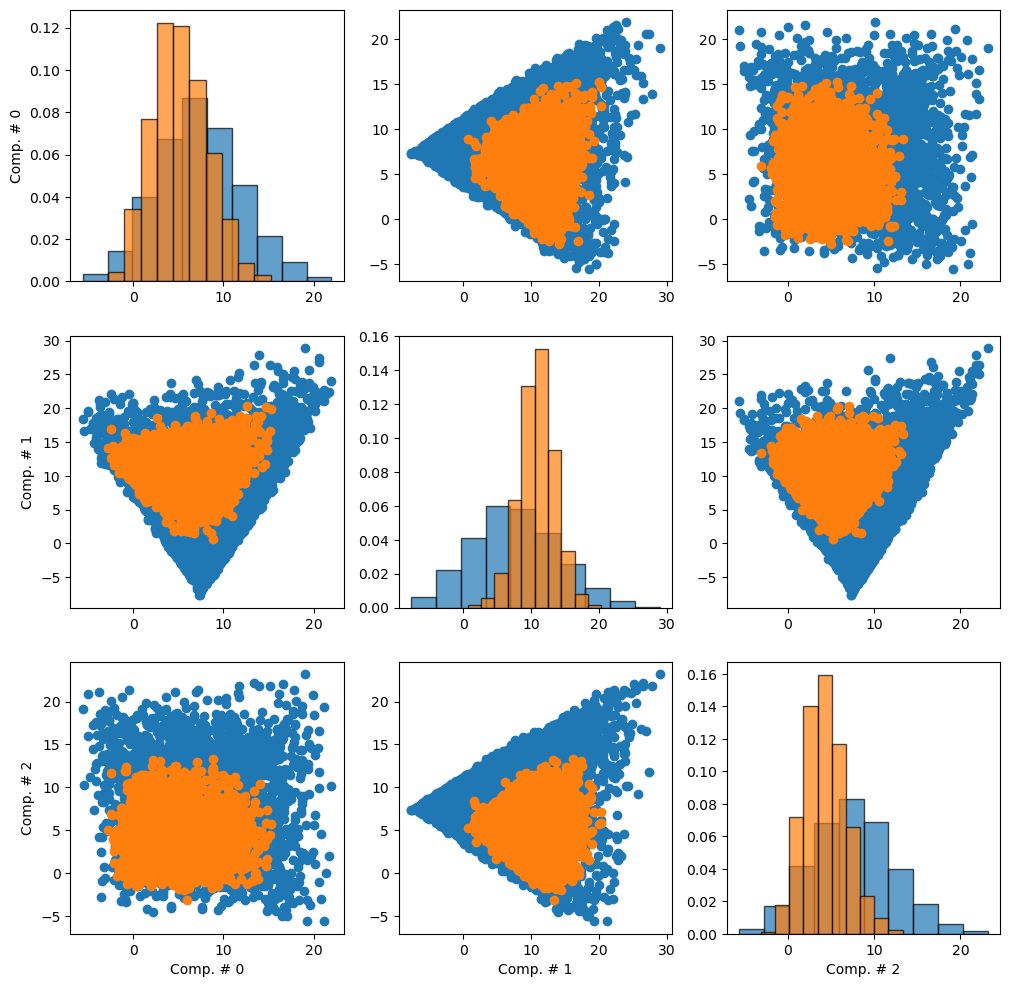

In [13]:
# i_list = [0,1,2,3]
# j_list = [0,1,2,3]
i_list = np.arange(d)
j_list = np.arange(d)

pred_qoi = q_sample_dict['pred']
obs_qoi = q_sample_dict['obs']
pred_import_qoi = q_sample_dict['import-pred']


fig,axes = plt.subplots(len(j_list),len(i_list))
fig.set_figwidth(len(i_list)*4)
fig.set_figheight(len(j_list)*4)

for i,ax_row in enumerate(axes):
    this_j = j_list[i]
    for j,ax in enumerate(ax_row):
        this_i = i_list[j]        
        if i==(len(axes)-1):
            ax.set_xlabel('Comp. # {}'.format(this_i))
        if j==0:
            ax.set_ylabel('Comp. # {}'.format(this_j))
            
        if this_i==this_j:
            ax.hist(pred_qoi[:,this_i],density=True,alpha=0.7,edgecolor='k')
            ax.hist(obs_qoi[:,this_i],density=True,alpha=0.7,edgecolor='k')
        else:
            ax.scatter(pred_qoi[:,this_i],pred_qoi[:,this_j])
            ax.scatter(obs_qoi[:,this_i],obs_qoi[:,this_j])
#             ax.scatter(pred_import_qoi[:,this_i],pred_import_qoi[:,this_j],alpha=0.2)                                    



In [14]:
# check mmd suffices in dim(d)
before = timeit.default_timer()
q1 = q_sample_dict['obs']
q2 = q_sample_dict['m-obs']
q_mmd = my_mmd(q1,q2)
after = timeit.default_timer()
print('Time (min): ',(after-before)/60)
print('MMD = ', q_mmd)



Time (min):  0.009844043016588937
MMD =  0.0004023371944752441


In [15]:
# observed kde
obs_kde = sps.gaussian_kde(q_sample_dict['obs'].T)
pred_kde = sps.gaussian_kde(q_sample_dict['pred'].T)

In [16]:
before = timeit.default_timer()
obs_kde.pdf(q_sample_dict['pred'].T)
after = timeit.default_timer()
print('Time (min): ',(after-before)/60)

Time (min):  0.006181196366863636


In [17]:
# check mmd between kde and observed
before = timeit.default_timer()
q1 = q_sample_dict['m-obs']
q2 = obs_kde.resample(n_monte).T
q_mmd = my_mmd(q1,q2)
after = timeit.default_timer()
print('Time (min): ',(after-before)/60)
print('MMD = ', q_mmd)




Time (min):  0.007937185866467189
MMD =  0.0006979001684682129


In [18]:
q_pred = q_sample_dict['pred']
before = timeit.default_timer()
this_r = obs_kde.pdf(q_pred.T)/pred_kde.pdf(q_pred.T)
after = timeit.default_timer()
print('Time (min): ',(after-before)/60)
print('Mean r = ',np.mean(this_r))

Time (min):  0.01136969069969685
Mean r =  1.0127982159505324


In [19]:
# accept-reject
M = np.max(this_r)
t = np.random.uniform(0,1,q_pred.shape[0])
accept_reject = np.less_equal(t,this_r/M)
print('Accepted: ',np.sum(accept_reject))
print('Accept ratio: ',np.sum(accept_reject)/len(accept_reject))
print('My expectations of acceptance rate: ',(1/2)**(2*(d-1)))

lam_update = lam_init_sample[:,accept_reject,:]

Accepted:  304
Accept ratio:  0.0608
My expectations of acceptance rate:  0.0625


In [20]:
# importance sampling
q_import_pred = q_sample_dict['import-pred']
before = timeit.default_timer()
this_import_r = obs_kde.pdf(q_import_pred.T)/pred_kde.pdf(q_import_pred.T)
this_import_r *= (0.5)**(2*(d-1))/lam_import_dist.pdf(*lam_import_sample)
after = timeit.default_timer()
print('Time (min): ',(after-before)/60)
print('Mean r = ',np.mean(this_import_r))

# importance sampling accept-reject
M = np.max(this_import_r)
print(M)
t = np.random.uniform(0,1,q_pred.shape[0])
import_accept_reject = np.less_equal(t,this_import_r/M)
print('Accepted: ',np.sum(import_accept_reject))
print('Accept ratio: ',np.sum(import_accept_reject)/len(import_accept_reject))
print('My expectations of acceptance rate: ',(1/2)**(2*(d-1)))

lam_import_update = lam_import_sample[:,import_accept_reject,:]

Time (min):  0.01142630856629694
Mean r =  0.9898291627235624
47.90248599076347
Accepted:  104
Accept ratio:  0.0208
My expectations of acceptance rate:  0.0625


(array([2.05417314e-01, 2.12932581e-03, 5.42769325e-04, 2.50508919e-04,
        2.50508919e-04, 0.00000000e+00, 4.17514866e-05, 4.17514866e-05,
        4.17514866e-05, 4.17514866e-05]),
 array([4.84380128e-51, 4.79024860e+00, 9.58049720e+00, 1.43707458e+01,
        1.91609944e+01, 2.39512430e+01, 2.87414916e+01, 3.35317402e+01,
        3.83219888e+01, 4.31122374e+01, 4.79024860e+01]),
 <BarContainer object of 10 artists>)

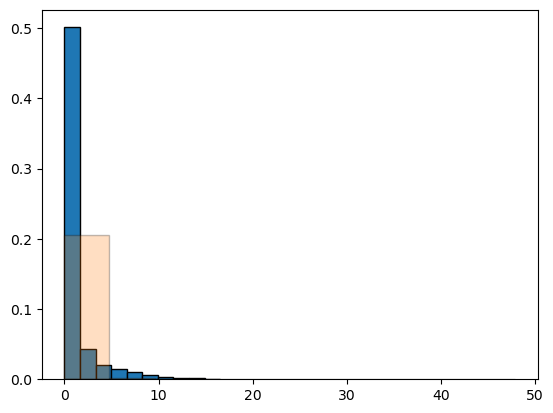

In [21]:
plt.hist(this_r,edgecolor='k',density=True)
plt.hist(this_import_r,edgecolor='k',density=True,alpha=0.25)


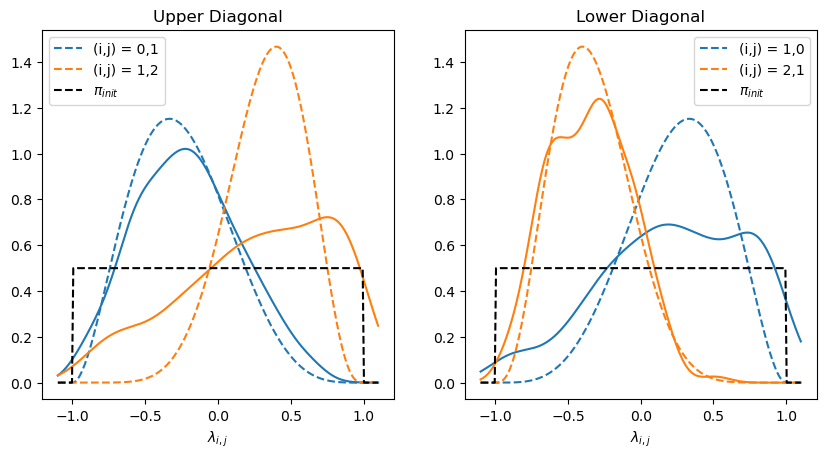

In [22]:
x = np.linspace(-1.1,1.1,250)

ys_gen = []
ys_init = []
for diag in [1,-1]:
    ys_gen.append(lam_gen_dist.diag_pdf(x,diag))
    ys_init.append(lam_init_dist.diag_pdf(x,diag))


fig,axes = plt.subplots(1,2)
fig.set_figwidth(len(axes)*5)
titles = ['Upper Diagonal','Lower Diagonal']
for k,ax in enumerate(axes):
    for i,y in enumerate(ys_gen[k]):
        labels = (i,i+1) if k==0 else (i+1,i)
        ax.plot(x,y,label='(i,j) = {},{}'.format(*labels),
                color='C{}'.format(i),ls='--')
        this_kde = sps.gaussian_kde(lam_init_sample[k][:,i],weights=accept_reject)
        ax.plot(x,this_kde.pdf(x))
    
    ax.plot(x,ys_init[0][k],ls='--',color='k',label='$\pi_{{init}}$')
    ax.set_xlabel('$\lambda_{{i,j}}$')
    ax.set_title(titles[k])
    ax.legend()

Here we use the size of the updated sample to compare the generating distribution to the generating distribution (should be $\approx0$) to see if sample size is sufficient to compute mmd.

In [23]:
# check mmd suffices in dim(lambda)
lam_test = lam_gen_dist.rvs(np.sum(accept_reject))
before = timeit.default_timer()
lam1 = np.hstack([lam_gen_sample[0],lam_gen_sample[1]])
lam2 = np.hstack([lam_test[0],lam_test[1]])
lam_mmd = my_mmd(lam1,lam2)
after = timeit.default_timer()
print('Time (min): ',(after-before)/60)
print('MMD = ', lam_mmd)



Time (min):  0.004431751800196556
MMD =  0.00015667813405606523


Difference between initial function and generating function.

In [24]:
# compute the mmd between the initial and generating samples
before = timeit.default_timer()
lam1 = np.hstack([lam_gen_sample[0],lam_gen_sample[1]])
lam2 = np.hstack([lam_init_sample[0],lam_init_sample[1]])
lam_mmd = my_mmd(lam1,lam2)
after = timeit.default_timer()
print('Time (min): ',(after-before)/60)
print('MMD = ', lam_mmd)

Time (min):  0.011129929017139753
MMD =  0.1363110035204278


This is the difference between the generating function and the update (we expect to be non-zero).

In [25]:
# check mmd between gen and update
before = timeit.default_timer()
lam1 = np.hstack([lam_gen_monte[0],lam_gen_monte[1]])
lam2 = np.hstack([lam_init_sample[0][accept_reject],lam_init_sample[1][accept_reject]])
lam_mmd = my_mmd(lam1,lam2)
after = timeit.default_timer()
print('Time (min): ',(after-before)/60)
print('MMD = ', lam_mmd)



Time (min):  0.002967945966520347
MMD =  0.013686832556370376


This is the difference between the initial function and the update, which we expect to be significantly different.

In [26]:
# check mmd between gen and update
before = timeit.default_timer()
lam1 = np.hstack([lam_init_sample[0],lam_init_sample[1]])
lam2 = np.hstack([lam_init_sample[0][accept_reject],lam_init_sample[1][accept_reject]])
lam_mmd = my_mmd(lam1,lam2)
after = timeit.default_timer()
print('Time (min): ',(after-before)/60)
print('MMD = ', lam_mmd)




Time (min):  0.004189645033329725
MMD =  0.09580081526922579


This shows that the update is closer to the generating function than the initial function.


In [27]:
# plt.plot(np.log(np.geomspace(5,10)))

In [28]:
# get kdes
this_rng = np.random.default_rng()
obs_sample_kdes = {}

for n in np.rint(np.geomspace(350,2e4,5)):
    print('Working on n = {}...'.format(int(n)))
    obs_sample_kdes[int(n)] = []
    
    for k in range(5):
        these_ind = this_rng.choice(n_obs,int(n))
        this_sample = q_sample_dict['obs'][these_ind]
        obs_sample_kdes[int(n)].append(sps.gaussian_kde(this_sample.T))


Working on n = 350...
Working on n = 962...
Working on n = 2646...
Working on n = 7274...
Working on n = 20000...


In [29]:
# evaluate mmd of observeds
obs_mmd_dict = {}

for n in obs_sample_kdes.keys():
    obs_mmd_dict[n] = []
    print('Working on n = {}...'.format(n))
    for k,this_kde in enumerate(obs_sample_kdes[n]):
        print('Set ',k)
        # check mmd between kde and observed
        before = timeit.default_timer()
        q1 = q_sample_dict['m-obs']
        q2 = this_kde.resample(int(n_monte/30)).T
        q_mmd = my_mmd(q1,q2)
        after = timeit.default_timer()
        print('Time (min): ',(after-before)/60)
        print('MMD = ', q_mmd)
        obs_mmd_dict[n].append(q_mmd)
        print()
    print('-------')




Working on n = 350...
Set  0
Time (min):  0.002830847050063312
MMD =  0.007628152351432223

Set  1
Time (min):  0.002946992433377697
MMD =  0.008627985931603972

Set  2
Time (min):  0.0023425615164645325
MMD =  0.008236300925026266

Set  3
Time (min):  0.0024862110997977047
MMD =  0.008881771327811191

Set  4
Time (min):  0.0023682156335174415
MMD =  0.01139074086260964

-------
Working on n = 962...
Set  0
Time (min):  0.0025284143499447963
MMD =  0.006381131270492488

Set  1
Time (min):  0.0023698646837146953
MMD =  0.00952499532946098

Set  2
Time (min):  0.002685346033346529
MMD =  0.008940839259442057

Set  3
Time (min):  0.0023616611336668334
MMD =  0.007935958081343071

Set  4
Time (min):  0.0025015104169142433
MMD =  0.006930808540403649

-------
Working on n = 2646...
Set  0
Time (min):  0.002355644966883119
MMD =  0.008289958522543828

Set  1
Time (min):  0.002479455316400466
MMD =  0.008700960312370581

Set  2
Time (min):  0.002381571999770434
MMD =  0.00882658469611794

Set

In [30]:
ns = np.array([[key]*5 for key in obs_mmd_dict.keys()])
mmds = np.array([obs_mmd_dict[key] for key in obs_mmd_dict.keys()])
print(mmds)

[[0.00762815 0.00862799 0.0082363  0.00888177 0.01139074]
 [0.00638113 0.009525   0.00894084 0.00793596 0.00693081]
 [0.00828996 0.00870096 0.00882658 0.00716537 0.00906633]
 [0.00647194 0.00779926 0.00910119 0.00535541 0.00790486]
 [0.0064505  0.0077958  0.0069448  0.00638155 0.00639139]]


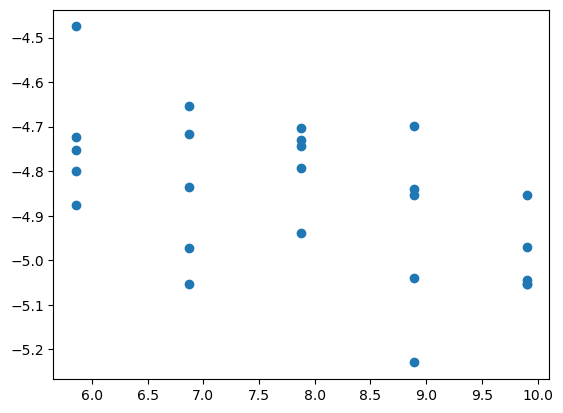

In [31]:
plt.scatter(np.log(ns.reshape(-1)),np.log(mmds.reshape(-1,)))

In [32]:
# evaluate r-values
r_dict = {}

for n in obs_sample_kdes.keys():
    r_dict[n] = []
    print('Working on n = {}...'.format(n))
    for k,this_kde in enumerate(obs_sample_kdes[n]):
        print('Set ',k)
        # check mmd between kde and observed
        before = timeit.default_timer()
        this_r = this_kde.pdf(q_pred.T)/pred_kde(q_pred.T)
        after = timeit.default_timer()
        print('Time (min): ',(after-before)/60)
        print('this_r = ', this_r.mean())
        r_dict[n].append(this_r)
        print()
    print('-------')





Working on n = 350...
Set  0
Time (min):  0.006598460166424047
this_r =  0.9933668235993064

Set  1
Time (min):  0.005455050533540392
this_r =  1.015391952400272

Set  2
Time (min):  0.005744046583519472
this_r =  1.0150231738609672

Set  3
Time (min):  0.005713305099925492
this_r =  0.999742658762628

Set  4
Time (min):  0.005577833650265044
this_r =  1.0134511036278524

-------
Working on n = 962...
Set  0
Time (min):  0.005981853250220107
this_r =  1.0147067048478906

Set  1
Time (min):  0.005991604516748339
this_r =  1.0219290687427678

Set  2
Time (min):  0.006233875733353974
this_r =  1.005492375988731

Set  3
Time (min):  0.006182352283212822
this_r =  1.0149631058551454

Set  4
Time (min):  0.007397360866889358
this_r =  1.012513232698879

-------
Working on n = 2646...
Set  0
Time (min):  0.010989974266946471
this_r =  1.0086782208632048

Set  1
Time (min):  0.010316294833319261
this_r =  1.0182779304819334

Set  2
Time (min):  0.009139283450106934
this_r =  1.017032543071824


In [33]:
update_dict = {}

for n in r_dict.keys():
    update_dict[n] = []
    for r in r_dict[n]:
        # accept-reject
        M = np.max(r)
        t = np.random.uniform(0,1,q_pred.shape[0])
        accept_reject = np.less_equal(t,r/M)
#         print('Accepted: ',np.sum(accept_reject))
#         print('Accept ratio: ',np.sum(accept_reject)/len(accept_reject))
#         print('My expectations of acceptance rate: ',(1/2)**(2*(d-1)))

        update_dict[n].append(lam_init_sample[:,accept_reject,:])

In [34]:
# evaluate mmd of observeds
update_mmd_dict = {}

for n in update_dict.keys():
    update_mmd_dict[n] = []
    print('Working on n = {}...'.format(n))
    for k,this_sample in enumerate(update_dict[n]):
#         print('Set ',k)
        # check mmd between kde and observed
        before = timeit.default_timer()
        lam1 = np.hstack([lam_update[0],lam_update[1]])
        lam2 = np.hstack([this_sample[0],this_sample[1]])
        lam_mmd = my_mmd(lam1,lam2)
        after = timeit.default_timer()
        print('Time (min): ',(after-before)/60)
#         print('MMD = ', lam_mmd)
        update_mmd_dict[n].append(lam_mmd)
        print()
    print('-------')





Working on n = 350...
Time (min):  4.3331250102104e-05

Time (min):  4.516389987353857e-05

Time (min):  3.609411651268601e-05

Time (min):  2.67256167717278e-05

Time (min):  3.3994449768215415e-05

-------
Working on n = 962...
Time (min):  3.686366641583542e-05

Time (min):  3.3771733190709106e-05

Time (min):  3.877823328366503e-05

Time (min):  3.8896716917709756e-05

Time (min):  3.698955018383761e-05

-------
Working on n = 2646...
Time (min):  3.693650020674492e-05

Time (min):  3.2936499822729576e-05

Time (min):  3.881604983083283e-05

Time (min):  4.064210030871133e-05

Time (min):  3.847383341053501e-05

-------
Working on n = 7274...
Time (min):  3.757940042608728e-05

Time (min):  3.7367850018199535e-05

Time (min):  3.791546672194575e-05

Time (min):  3.412648317559312e-05

Time (min):  3.594731630679841e-05

-------
Working on n = 20000...
Time (min):  3.685636669009303e-05

Time (min):  3.607226681197062e-05

Time (min):  3.660821676021442e-05

Time (min):  3.963373310

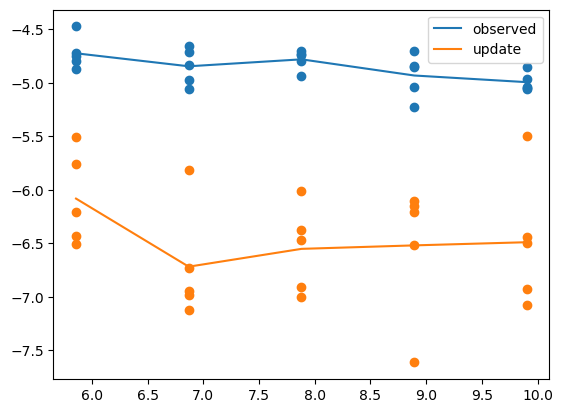

In [35]:
u_mmds = np.array([update_mmd_dict[key] for key in update_mmd_dict.keys()])
plt.scatter(np.log(ns.reshape(-1)),np.log(mmds.reshape(-1,)))
plt.plot(np.log(ns[:,0]),np.log(mmds).mean(axis=1),color='C0',label='observed')
plt.scatter(np.log(ns.reshape(-1)),np.log(u_mmds.reshape(-1,)))
plt.plot(np.log(ns[:,0]),np.log(u_mmds).mean(axis=1),color='C1',label='update')
plt.legend()

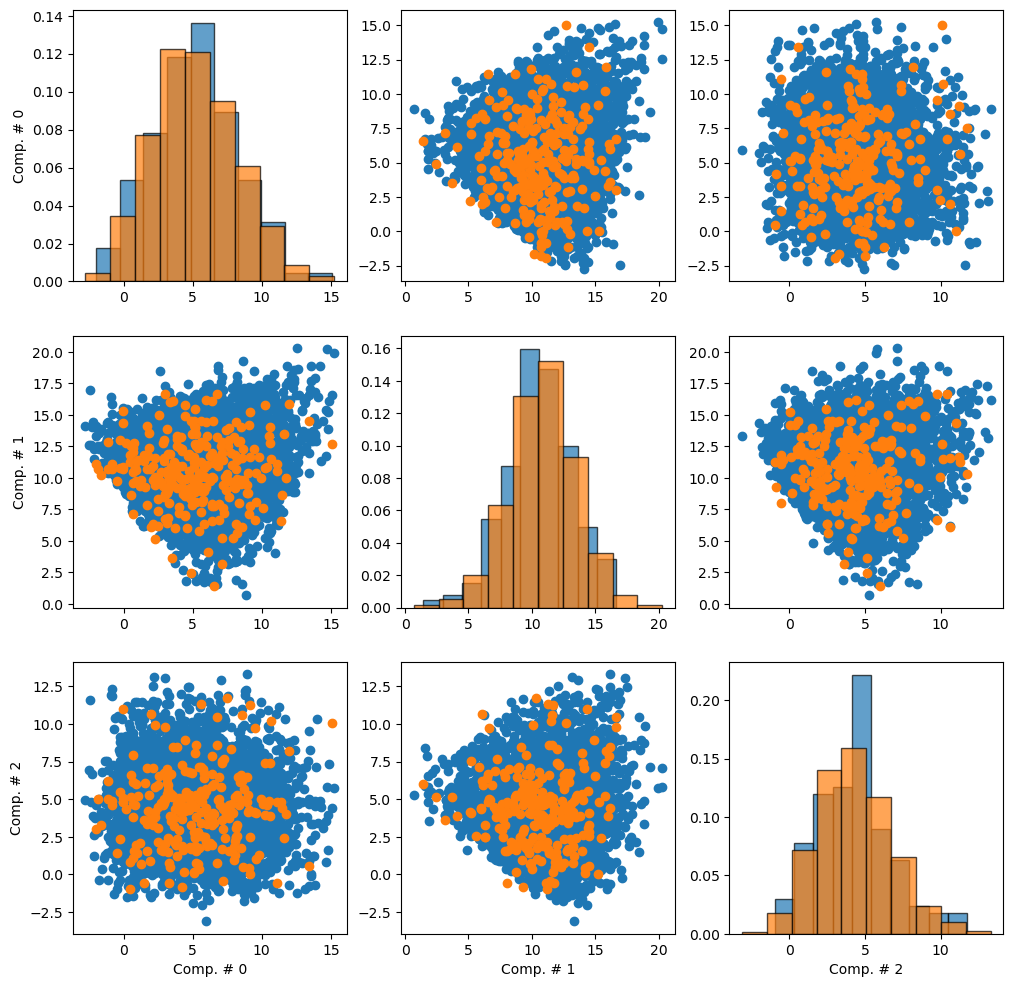

In [36]:
# i_list = [0,1,2,3]
# j_list = [0,1,2,3]
i_list = np.arange(d)
j_list = np.arange(d)

pred_qoi = q_sample_dict['pred']
obs_qoi = q_sample_dict['obs']

fig,axes = plt.subplots(len(j_list),len(i_list))
fig.set_figwidth(len(i_list)*4)
fig.set_figheight(len(j_list)*4)

for i,ax_row in enumerate(axes):
    this_j = j_list[i]
    for j,ax in enumerate(ax_row):
        this_i = i_list[j]        
        if i==(len(axes)-1):
            ax.set_xlabel('Comp. # {}'.format(this_i))
        if j==0:
            ax.set_ylabel('Comp. # {}'.format(this_j))
            
        if this_i==this_j:
            ax.hist(pred_qoi[accept_reject,this_i],density=True,alpha=0.7,edgecolor='k')
            ax.hist(obs_qoi[:,this_i],density=True,alpha=0.7,edgecolor='k')
        else:
            ax.scatter(obs_qoi[:,this_i],obs_qoi[:,this_j])
            ax.scatter(pred_qoi[accept_reject,this_i],pred_qoi[accept_reject,this_j])
        




In [37]:
lam_init_sample.shape

(2, 5000, 2)

In [38]:
# check mmd between update and generating
lam_update = lam_init_sample[:,accept_reject,:]
before = timeit.default_timer()
lam1 = np.hstack([lam_gen_monte[0],lam_gen_monte[1]])
lam2 = np.hstack([lam_update[0],lam_update[1]])
lam_mmd = my_mmd(lam1,lam2)
after = timeit.default_timer()
print('Time (min): ',(after-before)/60)
print('MMD = ', lam_mmd)




Time (min):  0.0029469599835768652
MMD =  0.011916279655189488


### Use Pytorch NN Density Estimation

In [38]:
import torch
import torch.nn as nn
import nn_modules as nn_cm

In [39]:
class ThisAutoFlowBN(nn.Module):
    def __init__(self,dim,nlayers,base_dist):
        super().__init__()
        self.nL = nlayers
        self.flow_layers = nn.ModuleList([nn_cm.AutoFlow(dim,2,3*[15]) for i in range(self.nL)])
        self.batch_norms = nn.ModuleList([nn_cm.ReversibleBatchNorm1d(dim) for i in range(self.nL)])
        
        # this base dist
        # assumed to be an iid distribution
        self.base_dist = base_dist 
        
    def forward(self,x):
        z = x
        logdet = torch.zeros(z.shape[0])
        for flow,norm in zip(self.flow_layers,self.batch_norms):
            # get flow transforms
            z,this_logdet = flow.sequential_forward(z)
            logdet += this_logdet
            
            # get the batchnorm transforms
            this_scale = norm.scale(z) # note, make sure to run scale first!
            logdet += torch.log(torch.abs(this_scale.prod()))
            z = norm.forward(z)
        
        return z, logdet
    
    def log_prob(self,x):
        this_z,logdet = self.forward(x)
        out = self.base_dist.log_prob(this_z).sum(axis=-1)
        out += logdet
        return out
    
    
    def inverse(self,z):
        x = z
        logdet = torch.zeros(x.shape[0])
        
        for i in range(self.nL):
            l = -i-1 # reverse order layers
            
            # get the batchnorm transforms
            this_scale = self.batch_norms[l].scale(x,inverse=True)
            logdet += torch.log(torch.abs(this_scale.prod()))
            x = self.batch_norms[l].inverse(x)            
            
            # get flow transforms
            x,this_logdet = self.flow_layers[l].sequential_backward(x)
            logdet += this_logdet
        
        return x,logdet

In [41]:
# set the torch seed
# torch.manual_seed(3251)

# define the base distribution
torch_iid_norm = torch.distributions.Normal(torch.zeros(d),torch.ones(d))

# define this autoflow
normal_bn_flow = ThisAutoFlowBN(d,4,torch_iid_norm)

# define the sample
q_obs_torch = torch.from_numpy(q_sample_dict['obs']).float()
q_test_torch = torch.from_numpy(q_sample_dict['m-obs']).float()

# define the optimizer
optimizer = torch.optim.Adam(normal_bn_flow.parameters(),lr=1e-3)

# mse regularizer
loss_fn = nn.MSELoss()

In [42]:
# I like to manually adapt the learning rate as it approaches a local min
adapt_lr = True
lr_iter = 0
adapt_patience = 100
adapt_lookback = 10

Nopt = int(2e2)
train_errs = np.zeros(Nopt)
test_errs = np.zeros(Nopt)
reg_lam = 5.

for t in range(Nopt):
    optimizer.zero_grad()
    
    # training loss
    this_z,this_logdet = normal_bn_flow.forward(q_obs_torch)
    this_log_prob = normal_bn_flow.base_dist.log_prob(this_z).sum(axis=-1)
    this_log_prob += this_logdet
    
    # get inverse
    this_q_hat,this_q_logdet = normal_bn_flow.inverse(this_z)
    
    loss = -this_log_prob.mean() + reg_lam*loss_fn(q_obs_torch,this_q_hat)
    train_errs[t] = loss.item()
    
    # test loss
    normal_bn_flow.eval()
    test_log_prob = normal_bn_flow.log_prob(q_test_torch)    
    test_loss = -test_log_prob.mean()
    test_errs[t] = test_loss.item()
    normal_bn_flow.train()
    
    lr_iter += 1

    if adapt_lr :
        if lr_iter>adapt_patience and train_errs[t]>1.0*train_errs[t-adapt_lookback] :
            optimizer.param_groups[0]['lr'] *= 0.5
            lr_iter = 0 # reset to 0 for new lr
            print('New learning rate: ' + str(optimizer.param_groups[0]['lr']))

    loss.backward()
    optimizer.step()
    if t % 1000 == 0:
        print("Finished optimization iteration "+str(t) + " with loss: " + str(train_errs[t]))

# when finished, make sure to...
normal_bn_flow.eval() # set batch_norm to eval mode instead of training mode
print('Eval mode on.')

Finished optimization iteration 0 with loss: 7.401069641113281
Eval mode on.


Train Err = 7.121425151824951 
 Test Err = 7.114295959472656


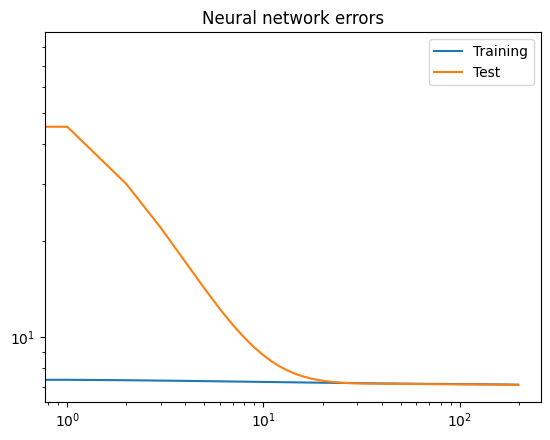

In [43]:
print('Train Err = {} \n Test Err = {}'.format(train_errs[-1],test_errs[-1]))
plt.title('Neural network errors')
# plt.plot(train_errs,label='Training')
# plt.plot(test_errs,label='Test')
plt.loglog(train_errs,label='Training')
plt.loglog(test_errs,label='Test')
plt.legend()

In [44]:
with torch.no_grad():
    z_gen = normal_bn_flow.base_dist.rsample([5000,])
    obs_nn_a,this_det = normal_bn_flow.inverse(z_gen)
    obs_nn_a = obs_nn_a.detach().numpy()

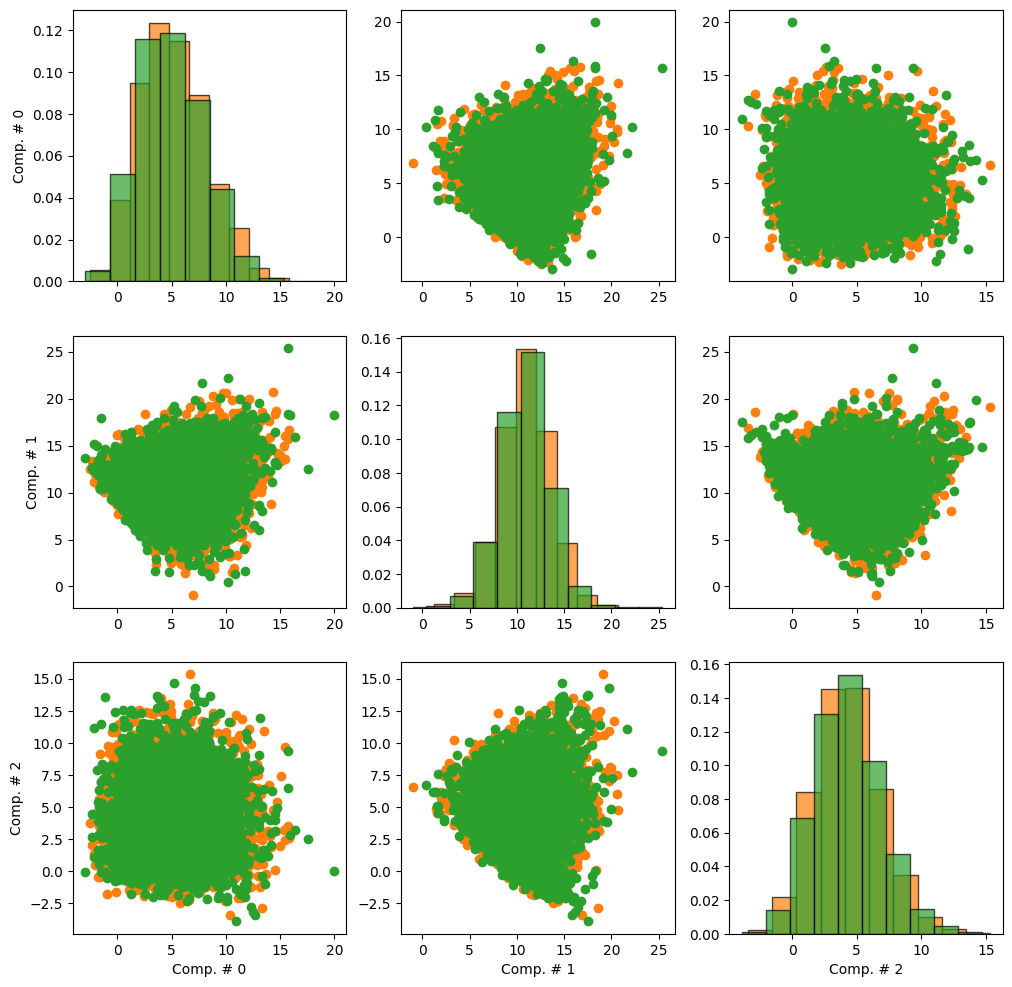

In [45]:
# i_list = [0,1,2,3]
# j_list = [0,1,2,3]
i_list = np.arange(d)
j_list = np.arange(d)

pred_qoi = q_sample_dict['pred']
obs_qoi = q_sample_dict['obs']

fig,axes = plt.subplots(len(j_list),len(i_list))
fig.set_figwidth(len(i_list)*4)
fig.set_figheight(len(j_list)*4)

for i,ax_row in enumerate(axes):
    this_j = j_list[i]
    for j,ax in enumerate(ax_row):
        this_i = i_list[j]        
        if i==(len(axes)-1):
            ax.set_xlabel('Comp. # {}'.format(this_i))
        if j==0:
            ax.set_ylabel('Comp. # {}'.format(this_j))
            
        if this_i==this_j:
#             ax.hist(pred_qoi[:,this_i],density=True,alpha=0.7,edgecolor='k')
            ax.hist(obs_qoi[:,this_i],density=True,alpha=0.7,edgecolor='k',color='C1')
            ax.hist(obs_nn_a[:,this_i],density=True,alpha=0.7,edgecolor='k',color='C2')    
        else:
#             ax.scatter(pred_qoi[:,this_i],pred_qoi[:,this_j])
            ax.scatter(obs_qoi[:,this_i],obs_qoi[:,this_j],color='C1')        
            ax.scatter(obs_nn_a[:,this_i],obs_nn_a[:,this_j],color='C2')        



In [46]:
# check mmd between nn and observed
before = timeit.default_timer()
q1 = q_sample_dict['m-obs']
q2 = obs_nn_a
q_mmd = my_mmd(q1,q2)
after = timeit.default_timer()
print('Time (min): ',(after-before)/60)
print('MMD = ', q_mmd)





Time (min):  0.009025076200000133
MMD =  0.000535575364312639


In [47]:
obs_kde_resample = obs_kde.resample(5000).T

In [48]:
# check mmd between nn and kde
before = timeit.default_timer()
q1 = obs_kde_resample
q2 = obs_nn_a
q_mmd = my_mmd(q1,q2)
after = timeit.default_timer()
print('Time (min): ',(after-before)/60)
print('MMD = ', q_mmd)






Time (min):  0.01073142574999982
MMD =  0.0008976598425493379


# --- OLD NOTES ETC. ---

## !!START HERE!! ##

**Proposition:**

Let $K_\Lambda$ and $K_D$ be two kernel functions used to define the IPM on probability measures of $\Lambda$ and $D$, respectively.

For the matrix exponential map defined in this problem, the errors in estimates of the update are bounded by the error estimates of the observed.

*Proof Outline*

1. If T is a bounded linear operator, then $\forall f\in\mathcal{H}(K_\Lambda)$, $\exists C>0$ such that
\begin{align}
\|Tf\|_{\mathcal{H}(K_D)}\leq C \|f\|_{\mathcal{H}(K_\Lambda)}
\end{align}


1. If the pull-back map of the kernel $T_Q:\mathcal{H}(K_D)\rightarrow \mathcal{H}(K_D\circ Q)$ is a bounded linear operator then [ref](https://www.math.uh.edu/~vern/rkhs.pdf)

## Analysis of Bound on IPM

* Other notes [on RKHS](https://www.gatsby.ucl.ac.uk/~gretton/coursefiles/lecture4_introToRKHS.pdf)

Let $\mathcal{F}_\Lambda$ be used to define an IPM for the update.

My previous analysis has shown that the key term to bound is:

\begin{align}
\tilde{g}(q)=\int_{\Lambda\cap Q^{-1}(q)} f(\lambda) \frac{\pi^{init}(\lambda)}{\pi^{pred}(Q(\lambda))}\,d\mu_{\Lambda,q} &= \int_{\Lambda\cap Q^{-1}(q)} f(\lambda) \pi^{init}_{\Lambda\mid q}(\lambda)\,d\mu_{\Lambda,q} = E_{\Lambda\mid q}(f)
\end{align}

for every $f\in\mathcal{F}_\Lambda$.

In a functional analysis context, we can interpret $E_{\Lambda\mid q}$ as a linear operator from $\mathcal{F}_\Lambda$ to a space of functions $\mathcal{G}_D$.

Now if the linear operator $E_{\lambda\mid q}$ is also bounded, then we can use $\mathcal{G}_D$ to define an IPM on the data space such that the difference between updates is less than the difference between approximations of predicted/observed in the data space.

Basically, if $E_{\lambda\mid q}$ is bounded, then there exists a $C>0$ such that $\forall f\in\mathcal{F}_\Lambda$,

\begin{align}
\left\|E_{\lambda\mid q}(f)\right\|_{\mathcal{G}_D} \leq C \left\|f\right\|_{\mathcal{F}_\Lambda} \leq C\cdot C_{\mathcal{F}_\Lambda}
\end{align}

where $C_{\mathcal{F}_\Lambda}$ is the bound on the class of functions used for the IPM (required by definition). Hence the class of functions $\mathcal{G}_D$ will be a set of real-valued, bounded, measurable functions, satisfying the requirement of an IPM.

Note that $\tilde{g}$ is not necessarily continuous.

**Proposition**

If $E_{\lambda\mid q}$ is not a bounded operator, then the stability condition fails.

*Proof:*

If $E_{\lambda\mid q}$ is **NOT** bounded, then $\forall C>0$, $\exists f\in\mathcal{F}_\Lambda$,

\begin{align}
\left\|E_{\lambda\mid q}(f)\right\|_{\mathcal{G}_D} \geq C \left\|f\right\|_{\mathcal{F}_\Lambda} \geq C\cdot C_{\mathcal{F}_\Lambda}
\end{align}

Choose $C$ to be the bound of the IPM defined on the measures of $D$, i.e., $C=C_{\mathcal{F}_D}$. Then, for some approximation $\pi-\tilde{\pi} > 0$,

\begin{align}
C_{\mathcal{F}_D}\cdot C_{\mathcal{F}_\Lambda} & \leq \left\|E_{\lambda\mid q}(f)\right\|_{\mathcal{G}_D} \\
\sup_{g\in\mathcal{F}_D}\left|\int g (\pi-\tilde{\pi})\ \right| &\leq C_{\mathcal{F}_D} \\
\sup_{f\in\mathcal{F}_\Lambda}\left|\int \left(E_{\lambda\mid q}f\right) (\pi-\tilde{\pi})\ \right| & ? \\
\left| I_\pi \left[\left(E_{\lambda\mid q}f\right)\right] \right| &\leq \|I_\pi\| \cdot\left\|\left(E_{\lambda\mid q}f\right)\right\|
\end{align}


**Proposition**

$E_{\lambda|q}$ is a bounded operator $\Rightarrow$ error is bounded.

Suppose $E_{\lambda\mid q}$ is bounded. Then for every $f\in\mathcal{F}_\Lambda$,

\begin{align}
\| E_{\lambda\mid q} f \|_{G} \leq C \|f\|_F
\end{align}

Therefore, there exists a $g\in G$ such that
\begin{align}
\dfrac{\| E_{\lambda\mid q} f \|_{G}}{C \|f\|_F} \leq 1
\end{align}

For every $f$, $\frac{E_{\lambda\mid q}f}{C*}\in G$


The following theorem is proved by [Vern I. Paulsen](https://www.math.uh.edu/~vern/rkhs.pdf).

**Theorem 5.14: Pull-backs**

Let $\Lambda$ and $D$ be sets and $Q:\Lambda\rightarrow D$ be a function. Let $K:D\times D\rightarrow \mathbb{R}$ be a positive definite kernel function.

Then $\mathcal{H}(K\circ Q)=\left\{f\circ Q: f\in \mathcal{H}(K)\right\}$ and for any $u\in\mathcal{H}(K\circ Q)$, $\|u\|_{\mathcal{H}(K\circ Q)}=\inf\{\|f\|_{\mathcal{H}(K)}: u=f\circ Q\}$

---thoughts---
Let $f\in\mathcal{H}$ such that $\|f\|_\mathcal{H}\leq 1$ and $\mathcal{H}$ is a reproducing kernel hilbert space over $\Lambda$.

Let $K$ be the reproducing kernel for $\mathcal{H}$. The Moore–Aronszajn theorem says that the hilbert space generated by this kernel is unique.

Now consider the set $\Lambda\cap Q^{-1}(q)$, which is a subset of $\Lambda$. 

**Proposition:**

Whenever the class of functions $\mathcal{F}_\Lambda$ is chosen so that $\left\| f \right\|_\infty < B$, then $E_{\Lambda\mid q}$ is always a bounded linear operator.

*Proof:*

Use Holder's inequality. For any $f\in\mathcal{F}_\Lambda$,

\begin{align}
\left|E_{\Lambda\mid q}(f)\right| &\leq \int_{\Lambda\cap Q^{-1}(q)} \left|f(\lambda)\right| \pi^{init}_{\Lambda\mid q}(\lambda)\,d\mu_{\Lambda,q} \\
&\leq \left\| f \right\|_{\infty (\Lambda\cap Q^{-1}(q))}\cdot \left\| \pi^{init}_{\Lambda\mid q}(\lambda) \right\|_{L_1(\Lambda\cap Q^{-1}(q))}\\
&\leq B \cdot 1
\end{align}

**Corollary:**

The Dudley metric has this property.

*Proof~ish:*

The Dudley metric is defined by the set of functions $\{f: \left\|f\right\|_\infty+\left\|f\right\|_L \leq 1 \}$, where $\left\|f\right\|_L$ is the Lipschitz semi-norm.

* [Random reference](https://www-users.cse.umn.edu/~wleeb/pubs/leeb_coifman.pdf)

In [ ]:
# evaluation values
tmeas = np.linspace(0,tf,7)


testA = [np.diag(u,1)+np.diag(l,-1)+np.diag(np.ones(d)) for u,l in zip(init_ud,init_ld)]



In [ ]:
# parameters
d = 5
tf = 1.
x0 = np.ones(d)
print('dim(D) = ',d)
print('dim(Lambda) = ',2*(d-1))

# generate sample matrices A
n_init = int(2e3)#100
lam_upper_init = sps.uniform(-1.1,2.2)
lam_lower_init = sps.uniform(-1.1,2.2)

# generate diagonal values
init_ud = lam_upper_init.rvs(size=[n_init,d-1])
init_ld = lam_lower_init.rvs(size=[n_init,d-1])

# evaluation values
tmeas = np.linspace(0,tf,7)



In [ ]:
import timeit

In [ ]:
# define ode model
before_r = timeit.default_timer()
this_model = ode_model(d,dvals=2.,x0=x0)
after_r = timeit.default_timer()

before_jit = timeit.default_timer()
jit_model = jit_ode_model(d,dvals=2.,x0=x0)
after_jit = timeit.default_timer()

print('Reg: ',after_r-before_r)
print('JIT: ',after_jit-before_jit)

In [ ]:
# before_r = timeit.default_timer()
# solutions = this_model.solve(tmeas,init_ud,init_ld)
# after_r = timeit.default_timer()
# print('Reg: ',after_r-before_r)

before_jit = timeit.default_timer()
jit_solutions = jit_model.solve(tmeas,init_ud,init_ld)
after_jit = timeit.default_timer()
print('JIT: ',after_jit-before_jit)

**<---- END COMPARE JIT VS. REG MODEL ---->**

In [ ]:
# parameters
d = 5
tf = 1.
x0 = np.ones(d)
print('dim(D) = ',d)
print('dim(Lambda) = ',2*(d-1))

# define ode model
this_ode_model = ode_model(d,dvals=2.,x0=x0)

# generate sample matrices A
n_init = int(2e3)#100
lam_upper_init = sps.uniform(-1.1,2.2)
lam_lower_init = sps.uniform(-1.1,2.2)
# lam_upper_init = sps.truncnorm(-3,3,scale=1.)
# lam_lower_init = sps.truncnorm(-3,3,scale=1.)

init_ud = lam_upper_init.rvs(size=[n_init,d-1])
init_ld = lam_lower_init.rvs(size=[n_init,d-1])

tmeas = np.linspace(0,tf,7)
solutions = this_ode_model.solve(tmeas,init_ud,init_ld)

In [ ]:
solutions.shape

In [ ]:
this_x = np.linspace(-1.5,1.5,300)
plt.plot(this_x,lam_upper_init.pdf(this_x))
plt.plot(this_x,lam_lower_init.pdf(this_x))
# ys = obs_dist.diag_pdf(this_x,1)
# for y in ys:
#     plt.plot(this_x,y)


In [ ]:
# plot some solutions
select_i = np.random.choice(np.arange(n_init),size=5,replace=False)
fig,axes = plt.subplots(1,len(select_i))
fig.set_figwidth(15)

for i,ax in enumerate(axes):
    for k,ys in enumerate(solutions[select_i[i]].T):
        ax.plot(tmeas,ys,marker='o',label='comp. # {}'.format(k))
#     ax.legend()

In [ ]:
# just solutions at final t
pred_qoi = this_ode_model.QoI(init_ud,init_ld)


In [ ]:
i_list = [0,1,2,3]
j_list = [0,1,2,3]
# i_list = np.arange(d)
# j_list = np.arange(d)



fig,axes = plt.subplots(len(j_list),len(i_list))
fig.set_figwidth(len(i_list)*4)
fig.set_figheight(len(j_list)*4)

for i,ax_row in enumerate(axes):
    this_j = j_list[i]
    for j,ax in enumerate(ax_row):
        this_i = i_list[j]        
        if i==(len(axes)-1):
            ax.set_xlabel('Comp. # {}'.format(this_i))
        if j==0:
            ax.set_ylabel('Comp. # {}'.format(this_j))
            
        if this_i==this_j:
            ax.hist(pred_qoi[:,this_i],density=True,alpha=0.7,edgecolor='k')
        else:
            ax.scatter(pred_qoi[:,this_i],pred_qoi[:,this_j])
        


In [ ]:
pred_kde = sps.gaussian_kde(pred_qoi.T)

In [ ]:
n_test = int(11e3)
pred_resample = pred_kde.resample(n_test).T

In [ ]:
i_list = [0,1,2,3]
j_list = [0,1,2,3]

fig,axes = plt.subplots(len(j_list),len(i_list))
fig.set_figwidth(len(i_list)*4)
fig.set_figheight(len(j_list)*4)

for i,ax_row in enumerate(axes):
    this_j = j_list[i]
    for j,ax in enumerate(ax_row):
        this_i = i_list[j]        
        if i==(len(axes)-1):
            ax.set_xlabel('Comp. # {}'.format(this_i))
        if j==0:
            ax.set_ylabel('Comp. # {}'.format(this_j))
            
        if this_i==this_j:
            ax.hist(pred_qoi[:,this_i],density=True,alpha=0.7,edgecolor='k')
            ax.hist(pred_resample[:,this_i],density=True,alpha=0.7,edgecolor='k')
        else:
            ax.scatter(pred_qoi[:,this_i],pred_qoi[:,this_j])
            ax.scatter(pred_resample[:,this_i],pred_resample[:,this_j],alpha=0.05)        



In [ ]:
# contains a number of pairwise kernels
import sklearn.metrics.pairwise as smp

In [ ]:
def metric_approx(rbf_mat,nA,nB):
    first = (1/nA)**2*np.sum(rbf_mat[:nA,:nA])
    second = (1/nB)**2*np.sum(rbf_mat[nA:nA+nB,nA:nA+nB])
    cross = -2/(nA*nB)*np.sum(rbf_mat[:nA,nA:nA+nB])
    return np.sqrt(first+second+cross)

In [ ]:
# generate sample matrices A
n_test = int(15e3)
# n_test = int(9e3)
kde_monte_resample = pred_kde.resample(n_test).T
udt = lam_upper_init.rvs(size=[n_test,d-1])
ldt = lam_lower_init.rvs(size=[n_test,d-1])
qoi_test = this_ode_model.QoI(udt,ldt)

# gaussian rbf kernel
c_sample = np.vstack([qoi_test,kde_monte_resample])
test_out = smp.rbf_kernel(c_sample)

In [ ]:
metric_approx(test_out,n_test,n_test)

In [ ]:
import timeit

In [ ]:
before = timeit.default_timer()
n_test = int(3e5)
udt = lam_upper_init.rvs(size=[n_test,d-1])
ldt = lam_lower_init.rvs(size=[n_test,d-1])
output = this_ode_model.QoI(udt,ldt)
after = timeit.default_timer()
print(after-before)

In [ ]:
before = timeit.default_timer()
pred_pdf = pred_kde(output.T)
after = timeit.default_timer()
print(after-before)

In [ ]:
before = timeit.default_timer()
obs_pdf = obs_kde(output.T)
after = timeit.default_timer()
print(after-before)

In [ ]:
this_r = obs_pdf/pred_pdf

In [ ]:
np.mean(this_r)

**Observed Distribution**

In [ ]:
n_obs = 850
obs_dist = gen_obs_diag_dist(d,ab_init=(2,6))
udsample,ldsample = obs_dist.rvs(n_obs)

obs_qoi = this_ode_model.QoI(udsample,ldsample)

In [ ]:
i_list = [0,1,2,3]
j_list = [0,1,2,3]
# i_list = np.arange(d)
# j_list = np.arange(d)

fig,axes = plt.subplots(len(j_list),len(i_list))
fig.set_figwidth(len(i_list)*4)
fig.set_figheight(len(j_list)*4)

for i,ax_row in enumerate(axes):
    this_j = j_list[i]
    for j,ax in enumerate(ax_row):
        this_i = i_list[j]        
        if i==(len(axes)-1):
            ax.set_xlabel('Comp. # {}'.format(this_i))
        if j==0:
            ax.set_ylabel('Comp. # {}'.format(this_j))
            
        if this_i==this_j:
            ax.hist(pred_qoi[:,this_i],density=True,alpha=0.7,edgecolor='k')
            ax.hist(obs_qoi[:,this_i],density=True,alpha=0.7,edgecolor='k')
        else:
            ax.scatter(pred_qoi[:,this_i],pred_qoi[:,this_j])
            ax.scatter(obs_qoi[:,this_i],obs_qoi[:,this_j])        




In [ ]:
obs_kde = sps.gaussian_kde(obs_qoi.T)
obs_resample = obs_kde.resample(n_test).T

obs_test = this_ode_model.QoI(*obs_dist.rvs(n_test))
# obs_kde = sps.gaussian_kde(obs_test.T)

In [ ]:
# i_list = [0,1,2,3]
# j_list = [0,1,2,3]

fig,axes = plt.subplots(len(j_list),len(i_list))
fig.set_figwidth(len(i_list)*4)
fig.set_figheight(len(j_list)*4)

for i,ax_row in enumerate(axes):
    this_j = j_list[i]
    for j,ax in enumerate(ax_row):
        this_i = i_list[j]        
        if i==(len(axes)-1):
            ax.set_xlabel('Comp. # {}'.format(this_i))
        if j==0:
            ax.set_ylabel('Comp. # {}'.format(this_j))
            
        if this_i==this_j:
            ax.hist(obs_qoi[:,this_i],density=True,alpha=0.7,edgecolor='k')
            ax.hist(obs_resample[:,this_i],density=True,alpha=0.7,edgecolor='k')            
        else:
#             ax.scatter(qoi[:,this_i],qoi[:,this_j])
            ax.scatter(obs_qoi[:,this_i],obs_qoi[:,this_j])        
            ax.scatter(obs_resample[:,this_i],obs_resample[:,this_j],alpha=0.3)                    





In [ ]:
# gaussian rbf kernel
c_sample = np.vstack([obs_test,obs_resample])
test_out = smp.rbf_kernel(c_sample)
obs_mmd = metric_approx(test_out,n_test,n_test)
print(obs_mmd)

c_sample = np.vstack([obs_resample,kde_monte_resample])
test_out = smp.rbf_kernel(c_sample)
obs_pred_mmd = metric_approx(test_out,n_test,n_test)
print(obs_pred_mmd)

In [ ]:
%%timeit -r 2 -n 35
obs_test = this_ode_model.QoI(*obs_dist.rvs(n_test))


In [ ]:
%%timeit -r 2 -n 35
test_out = smp.rbf_kernel(c_sample,gamma=1/d)

In [ ]:
n_test_list = [5e3,9e3,11e3,n_test]

mmd_list = []
for n in n_test_list:
    print('Computing: n = {}...'.format(int(n)))
    obs_test = this_ode_model.QoI(*obs_dist.rvs(int(n)))
    obs_test2 = this_ode_model.QoI(*obs_dist.rvs(int(n)))
    c_sample = np.vstack([obs_test,obs_test2])
    test_out = smp.rbf_kernel(c_sample,gamma=1/d)
    obs_obs2_mmd = metric_approx(test_out,n_test,n_test)
    s = obs_obs2_mmd
                                       
    mmd_list.append(s)

In [ ]:
err_average = np.array([np.mean(s) for s in mmd_list])
print(err_average[-1])
err_bars = 3*np.array([np.std(s) for s in mmd_list])
plt.plot(np.array(n_test_list),err_average,marker='o')
# plt.errorbar(np.array(n_test_list),err_average,yerr=err_bars)
plt.hlines(obs_mmd,xmin=n_test_list[0],xmax=n_test_list[-1],
           label='n = {}'.format(n_test),color='xkcd:green')
plt.legend()


In [ ]:
obs_kde2 = sps.gaussian_kde(obs_test2.T)

In [ ]:
test_r = obs_kde(obs_test.T)/obs_kde2(obs_test.T)
print(test_r.mean())

In [ ]:
np.mean(1/test_r)

In [ ]:
err_average[-1]

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2)
this_x = np.linspace(-1.1,1.1,350)

upper_ys = obs_dist.diag_pdf(this_x,1)
lower_ys = obs_dist.diag_pdf(this_x,-1)

for y1,y2 in zip(upper_ys,lower_ys):
    ax1.plot(this_x,y1)
    ax2.plot(this_x,y2)
    ax1.plot(this_x,sps.uniform(-1,2).pdf(this_x),ls='--',color='k')
    ax2.plot(this_x,sps.uniform(-1,2).pdf(this_x),ls='--',color='k')    

In [ ]:
this_r = obs_kde(pred_qoi.T)/pred_kde(pred_qoi.T)
print(np.mean(this_r))

In [ ]:
this_r.shape

In [ ]:
k

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2)
this_x = np.linspace(-1.1,1.1,350)

upper_ys = obs_dist.diag_pdf(this_x,1)
lower_ys = obs_dist.diag_pdf(this_x,-1)

for y1,y2 in zip(upper_ys,lower_ys):
    ax1.plot(this_x,y1)
    ax2.plot(this_x,y2)
    ax1.plot(this_x,sps.uniform(-1,2).pdf(this_x),ls='--',color='k')
    ax2.plot(this_x,sps.uniform(-1,2).pdf(this_x),ls='--',color='k')    
    
for k in range(d-1):
    this_kde_U = sps.gaussian_kde(init_ud[:,k],weights=this_r)
    ax1.plot(this_x,this_kde_U.pdf(this_x),color='C{}'.format(k),ls=':')
    
    this_kde_L = sps.gaussian_kde(init_ld[:,k],weights=this_r)    
    ax2.plot(this_x,this_kde_L.pdf(this_x),color='C{}'.format(k),ls=':')    

In [ ]:
4%2

In [ ]:
this_dist = sps.beta(5,11,loc=-1,scale=2)
this_x = np.linspace(-1,1,350)
plt.plot(this_x,this_dist.pdf(this_x))

In [ ]:
n_obs = 500
udsample = np.random.uniform(-1,1,size=[n_obs,d-1])
ldsample = np.random.uniform(-1,1,size=[n_obs,d-1])

sample_mat = np.zeros([n_obs,d,d])
for i,(uval,lval) in enumerate(zip(udsample,ldsample)):
    sample_mat[i] = np.diag(uval,1) + np.diag(lval,-1) + np.diag(2*np.ones(d))
A = sample_mat

In [ ]:
n_obs = 850
this_dist = gen_obs_diag_dist(d,ab_init=(2,6))
udsample,ldsample = this_dist.rvs(n_obs)

A = np.zeros([n_obs,d,d])
for i,(uval,lval) in enumerate(zip(udsample,ldsample)):
    A[i] = np.diag(uval,1) + np.diag(lval,-1) + np.diag(2*np.ones(d))



In [ ]:
this_ode_mod = ode_model(d)

In [ ]:
test_samp = this_ode_mod.QoI(udsample,ldsample)

In [ ]:
plt.scatter(test_samp[:,0],test_samp[:,4])

In [ ]:
test_ode_vals = this_ode_mod.solve(tmeas,udsample,ldsample)

In [ ]:
for vals in test_ode_vals[0].T:
    plt.plot(tmeas,vals,marker='o')

In [ ]:
this_ode_mod.get_A(udsample,ldsample).shape

In [ ]:
this_x = np.linspace(-1,1,350)
these_ys = this_dist.diag_pdf(this_x,-1)
for i in range(d-1):
    this_kde = sps.gaussian_kde(A[:,i,i+1])
#     plt.plot(this_x,this_kde.pdf(this_x),label=i)
    plt.plot(this_x,these_ys[i],label=i)
plt.legend()

In [ ]:
# i,j = 4,3
# this_x = np.linspace(-1,1,350)
# plt.hist(A[:,i,j],density=True)
# plt.plot(this_x,sps.beta(3+i,5+3*i,-1,2).pdf(this_x))

In [ ]:
# add_interact = np.random.uniform(-1.,1.,[n_obs,d,d])
# add_interact = np.random.normal(size=[n_obs,d,d])/d
# A = A[np.newaxis,:,:]+np.tril(add_interact,-kd)+np.triu(add_interact,kd)
# A = A[np.newaxis,:,:]

In [ ]:
15**2-15

In [ ]:
A.shape

In [ ]:
A[0]

In [ ]:
# np.dot(expm(tmeas[-1]*A[0]),np.ones(5))

In [ ]:
output = np.zeros([n_obs,len(tmeas),d])
for i,A_obs in enumerate(A):
    for k,t in enumerate(tmeas):
        output[i,k,:] = np.dot(expm(t*A_obs),x0)
print(output.shape)

\begin{align}
t^{-1}\log\left(x(t)x_0^{-1}\right) = A
\end{align}

In [ ]:
x0

In [ ]:
np.exp(np.diff(np.log(np.abs(output[0])),axis=0))

In [ ]:
2/1.7

In [ ]:
output[4]

In [ ]:
output[:,3,k:k+2].shape

In [ ]:
kx,ky = (3,4)
# plt.scatter(*(output[:,3,(kx,ky)]/np.atleast_2d(x0)[:,(kx,ky)]).T)
plt.scatter(*(output[:,3,(kx,ky)]).T)
# plt.scatter(*output[73].T)
# plt.xlim(-10,10)
# plt.ylim(-10,10)

In [ ]:
output[0]

In [ ]:
i = 8
# print(A[i])
for k,out in enumerate(output[i].T):
    plt.plot(tmeas[0:4],out[0:4],marker='o',label='k={}'.format(k))
    plt.legend()